In [10]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import spearmanr
from scipy.stats import linregress
from scipy.stats import mannwhitneyu

# Step 1: Crawling a Real-World Dataset


## NASA APIs

In [103]:
api_key = 'UglAOBjifjh9sR56v36GEjQHlPbddV236j6KJWyo'
flare_url = 'https://api.nasa.gov/DONKI/FLR?'
hss_url = 'https://api.nasa.gov/DONKI/HSS?'
cme_url = 'https://api.nasa.gov/DONKI/CMEAnalysis?'
ips_url = 'https://api.nasa.gov/DONKI/IPS?'
kp_url = 'https://kp.gfz-potsdam.de/app/json/'
index = 'Kp'
start_date = '2021-01-01'
end_date = '2024-01-01'

In [104]:
def get_nasa_api(base_url, start_date=start_date, end_date=end_date, api_key=api_key):
    params = {'startDate': start_date,  
    'endDate': end_date,   
    'api_key': api_key}
    try:
        request = requests.get(base_url, params=params)
        data = json.loads(request.content) 
        return pd.DataFrame(data)
    except:
        print('An Error Occured')

In [105]:
original_flare_df = get_nasa_api(flare_url)
original_hss_df = get_nasa_api(hss_url)
original_cme_df = get_nasa_api(cme_url)
original_ips_df = get_nasa_api(ips_url)

original_flare_df.to_csv("flare_data.csv", index=False)
original_hss_df.to_csv("hss_data.csv", index=False)
original_cme_df.to_csv("cme_data.csv", index=False)
original_ips_df.to_csv("ips_data.csv", index=False)


## KP INDEX API

In [106]:
from datetime import datetime
import json, urllib.request

def __checkdate__(starttime,endtime):
    if starttime > endtime:
        raise NameError("Error! Start time must be before or equal to end time")
    return True

def __checkIndex__(index):
    if index not in ['Kp', 'ap', 'Ap', 'Cp', 'C9', 'Hp30', 'Hp60', 'ap30', 'ap60', 'SN', 'Fobs', 'Fadj']:
        raise IndexError("Error! Wrong index parameter! \nAllowed are only the string parameter: 'Kp', 'ap', 'Ap', 'Cp', 'C9', 'Hp30', 'Hp60', 'ap30', 'ap60', 'SN', 'Fobs', 'Fadj'")
    return True

def __checkstatus__(status):
    if status not in ['all', 'def']:
        raise IndexError("Error! Wrong option parameter! \nAllowed are only the string parameter: 'def'")
    return True
       
def __addstatus__(url,status):
    if status == 'def':
        url = url + '&status=def'
    return url 

def getKpindex(starttime, endtime, index, status='all'):
    """
    ---------------------------------------------------------------------------------
    download 'Kp', 'ap', 'Ap', 'Cp', 'C9', 'Hp30', 'Hp60', 'ap30', 'ap60', 'SN', 'Fobs' or 'Fadj' index data from kp.gfz-potsdam.de
    date format for starttime and endtime is 'yyyy-mm-dd' or 'yyyy-mm-ddTHH:MM:SSZ'
    optional 'def' parameter to get only definitve values (only available for 'Kp', 'ap', 'Ap', 'Cp', 'C9', 'SN')
    Hpo index and Fobs/Fadj does not have the status info
    example: (time, index, status) = getKpindex('2021-09-29', '2021-10-01','Ap','def')
    example: (time, index, status) = getKpindex('2021-09-29T12:00:00Z', '2021-10-01T12:00:00Z','Kp')
    ---------------------------------------------------------------------------------
    """
    result_t=0; result_index=0; result_s=0

    if len(starttime) == 10 and len(endtime) == 10:
        starttime = starttime + 'T00:00:00Z'
        endtime = endtime + 'T23:59:00Z'

    try:
        d1 = datetime.strptime(starttime, '%Y-%m-%dT%H:%M:%SZ')
        d2 = datetime.strptime(endtime, '%Y-%m-%dT%H:%M:%SZ')

        __checkdate__(d1,d2)
        __checkIndex__(index)  
        __checkstatus__(status)

        time_string = "start=" + d1.strftime('%Y-%m-%dT%H:%M:%SZ') + "&end=" + d2.strftime('%Y-%m-%dT%H:%M:%SZ')
        url = 'https://kp.gfz-potsdam.de/app/json/?' + time_string  + "&index=" + index
        if index not in ['Hp30', 'Hp60', 'ap30', 'ap60', 'Fobs', 'Fadj']:
            url = __addstatus__(url, status)

        webURL = urllib.request.urlopen(url)
        binary = webURL.read()
        text=binary.decode('utf-8')
    
        try:
            data = json.loads(text)
            result_t = tuple(data["datetime"])
            result_index = tuple(data[index])
            if index not in ['Hp30', 'Hp60', 'ap30', 'ap60', 'Fobs', 'Fadj']:
                result_s = tuple(data["status"])
        except:
            print(text)

    except NameError as er:
        print(er)
    except IndexError as er:
        print(er)
    except ValueError:
        print("Error! Wrong datetime string")
        print("Both dates must be the same format.")
        print("Datetime strings must be in format yyyy-mm-dd or yyyy-mm-ddTHH:MM:SSZ")
    except urllib.error.URLError:
        print("Connection Error\nCan not reach " + url)
    finally:
        return result_t, result_index, result_s

In [107]:
index = "Kp"
status = "def"

time, kp_values, statuses = getKpindex(start_date, end_date, index, status)

In [108]:
original_kp_index_df = pd.DataFrame({
        "Datetime": time,
        "Kp Index": kp_values,
        "Status": statuses
    })

original_kp_index_df.to_csv("kp_index_data.csv", index=False)

#### Where Does the Data Come From?
The data was obtained from two primary sources:

1. **NASA Open APIs (DONKI - Space Weather Database Of Notifications, Knowledge, Information)**:
   - These APIs provide space weather data and require an API key for access. The specific endpoints used include:
     - **CME (Coronal Mass Ejection) API**: Provides data about massive solar eruptions that eject plasma and magnetic fields from the Sun's corona.
     - **HSS (High-Speed Solar Wind Stream) API**: Contains information about streams of solar wind emanating from coronal holes, which can interact with Earth's magnetosphere.
     - **IPS (Interplanetary Shock) API**: Tracks sudden changes in solar wind properties caused by CME or other solar wind structures.
     - **Solar Flare API**: Includes data about solar flares, which are sudden bursts of energy resulting from magnetic activity on the Sun's surface.

2. **Kp Index API (GFZ Potsdam)**:
   - The Kp index data, which measures geomagnetic activity, was sourced from the [GFZ Potsdam Kp Index Data Service](https://kp.gfz-potsdam.de/en/data#c42). This service provided a Python function to fetch data via an API. Unlike the NASA APIs, no API key was required.

#### How Was the Data Collected?
- **NASA APIs**:
  - A custom Python function (`get_nasa_api`) was implemented to:
    1. Define the parameters for each API request, including the `start_date`, `end_date`, and the `API key`.
    2. Send a GET request to the respective API endpoint.
    3. Parse the returned JSON data into a Pandas DataFrame.
  - Data was collected for the time range `2021-01-01` to `2024-01-01` and saved as CSV files for reproducibility.

- **Kp Index API**:
  - The provided Python function from GFZ Potsdam was executed to fetch the Kp index data, which was returned in JSON format. The data was converted to a Pandas DataFrame and saved as a CSV file.

#### What Are the Variables of Interest?
Each dataset contains specific variables critical for the analysis:
- **CME Data**:
  - `Time of Event`: Timestamp of the CME.
  - `Speed`: Velocity of the CME (km/s).
  - `Half-Angle`: Angular width of the CME (degrees).
  - `Latitude` and `Longitude`: CME's position on the solar surface.
  - `CME Type`: Classification of the CME event.

- **HSS Data**:
  - `Time of Event`: Timestamp of high-speed solar wind streams.

- **IPS Data**:
  - `Time of Event`: Timestamp of interplanetary shock occurrences.

- **Solar Flare Data**:
  - `Start Time`, `Peak Time`, `End Time`: Key timestamps of the flare event.
  - `Type`: Classification of the flare (e.g., M-class or X-class). This analysis focuses on **strong solar flares** (M/X class).

- **Kp Index Data**:
  - `Time of Observation`: Timestamp of geomagnetic activity measurement.
  - `Kp Value`: A numerical index (0-9) that quantifies geomagnetic disturbances.

#### Why Are These Variables Important?
These variables provide essential information about solar activity and its influence on Earth's geomagnetic environment:
- CME speed and angular width (half-angle) help assess the potential scale and severity of solar eruptions.
- HSS and IPS events indicate solar wind properties and shocks that could disturb Earth's magnetosphere.
- Flare classifications and timings capture the intensity and duration of solar flares.
- The Kp index quantifies the level of geomagnetic disturbance caused by solar activity.

# Step 2: Data Preparation 

In [86]:
flare_df = pd.read_csv("flare_data.csv")
hss_df = pd.read_csv("hss_data.csv")
ips_df = pd.read_csv("ips_data.csv")
cme_df = pd.read_csv("cme_data.csv")
kp_index_df = pd.read_csv("kp_index_data.csv")

In [87]:
#Problem in the data
flare_df['endTime'] = flare_df['endTime'].str.replace('^0023', '2023', regex=True)
flare_df['peakTime'] = flare_df['peakTime'].str.replace('^0021', '2021', regex=True)

#Convert relevant columns to datetime
kp_index_df['Datetime'] = pd.to_datetime(kp_index_df['Datetime'])
cme_df['time21_5'] = pd.to_datetime(cme_df['time21_5'])
flare_df['beginTime'] = pd.to_datetime(flare_df['beginTime'])
flare_df['peakTime'] = pd.to_datetime(flare_df['peakTime'])
flare_df['endTime'] = pd.to_datetime(flare_df['endTime'])
hss_df['eventTime'] = pd.to_datetime(hss_df['eventTime'])
ips_df['eventTime'] = pd.to_datetime(ips_df['eventTime'])

#Keep only Earth-based IPS events
ips_df = ips_df[ips_df['location'] == 'Earth']

#Calculate Travel Time and Adjust Timeslot for CME
cme_df['Travel Time (hours)'] = (1.496e+8 / cme_df['speed']) / 3600  # Distance in km, speed in km/s
cme_df['Adjusted CME Time'] = cme_df['time21_5'] + pd.to_timedelta(cme_df['Travel Time (hours)'], unit='h')

#Assign Timeslot
kp_index_df['Timeslot'] = kp_index_df['Datetime'].dt.floor('3H')
cme_df['Timeslot'] = cme_df['Adjusted CME Time'].dt.floor('3H')
flare_df['Timeslot'] = flare_df['peakTime'].dt.floor('3H')
hss_df['Timeslot'] = hss_df['eventTime'].dt.floor('3H')
ips_df['Timeslot'] = ips_df['eventTime'].dt.floor('3H')

#Find CME Count and Average CME Speed
cme_df['CME Count'] = cme_df.groupby('Timeslot')['speed'].transform('count')
cme_df['Average CME speed'] = cme_df.groupby('Timeslot')['speed'].transform('mean')
cme_df = cme_df.sort_values(by='speed', ascending=False).drop_duplicates(subset='Timeslot')
cme_df.rename(columns={'speed': 'Fastest CME speed',
                       'latitude': 'Latitude of Fastest CME',
                       'longitude': 'Longitude of Fastest CME',
                       'halfAngle': 'Half Angle of Fastest CME',
                       'type': 'Fastest CME Type'}, inplace=True)

#Calculate the total number of flares and strong flares per timeslot
flare_df['Flare Count'] = flare_df.groupby('Timeslot')['classType'].transform('count')
flare_df['Strong Flare'] = flare_df['classType'].str.startswith(('M', 'X')).astype(int)
flare_df['Strong Flare Count'] = flare_df.groupby('Timeslot')['Strong Flare'].transform('sum')

#Calculate the average flare length for each timeslot
flare_df['Flare Length'] = (flare_df['endTime'] - flare_df['beginTime']).dt.total_seconds() / 60  #Convert to minutes
flare_df = flare_df[flare_df['Flare Length'] > 0]  #Remove negative flare lengths (these are mistakes)
flare_df['Average Flare Length'] = flare_df.groupby('Timeslot')['Flare Length'].transform('mean')

#Drop duplicates to consolidate data by timeslot
flare_df = flare_df.drop_duplicates(subset='Timeslot')

#Find the total number of HSS events per timeslot and drop duplicates
hss_df['HSS Count'] = hss_df.groupby('Timeslot')['eventTime'].transform('count')
hss_df = hss_df.drop_duplicates(subset='Timeslot')

#Find the total number of IPS events per timeslot and drop duplicates
ips_df['IPS Count'] = ips_df.groupby('Timeslot')['eventTime'].transform('count')
ips_df = ips_df.drop_duplicates(subset='Timeslot')

#Merge datasets
merged_df = pd.merge(kp_index_df[['Timeslot', 'Kp Index']],
                     cme_df[['Timeslot', 'CME Count', 'Average CME speed', 'Fastest CME speed',
                             'Latitude of Fastest CME',
                             'Longitude of Fastest CME',
                             'Half Angle of Fastest CME',
                             'Fastest CME Type']],
                     on='Timeslot',
                     how='left')


merged_df = pd.merge(merged_df,
                     flare_df[['Timeslot', 'Flare Count', 'Strong Flare Count', 'Average Flare Length']],
                     on='Timeslot',
                     how='left')

merged_df = pd.merge(merged_df,
                     hss_df[['Timeslot', 'HSS Count']],
                     on='Timeslot',
                     how='left')

merged_df = pd.merge(merged_df,
                     ips_df[['Timeslot', 'IPS Count']],
                     on='Timeslot',
                     how='left')


merged_df['CME Count'] = merged_df['CME Count'].fillna(0).astype(int)
merged_df['Flare Count'] = merged_df['Flare Count'].fillna(0).astype(int)
merged_df['Strong Flare Count'] = merged_df['Strong Flare Count'].fillna(0).astype(int)
merged_df['HSS Count'] = merged_df['HSS Count'].fillna(0).astype(int)
merged_df['IPS Count'] = merged_df['IPS Count'].fillna(0).astype(int)

boolean = not merged_df["Timeslot"].is_unique 
print("Duplicates? " + str(boolean))


Duplicates? False


In [88]:
merged_df.to_csv("merged_data.csv", index=False)

#### Overview
To prepare the raw data collected from the NASA APIs and Kp index API, several transformation and feature extraction steps were performed. These steps ensured that the data was consistent and suitable for analysis.

---

#### Data Preparation Steps

1. **Fixing Errors in the Data**:
   - Some timestamps in the Solar Flare dataset had incorrect year values (e.g., `0023` instead of `2023` and `0021` instead of `2021`). These were corrected using string replacement.

2. **Converting Timestamps**:
   - All relevant date and time columns across the datasets (e.g., flare start, peak, and end times; CME event time; HSS and IPS event times; Kp index timestamps) were converted to Python `datetime` objects for consistency and easier processing.

3. **Filtering the IPS Data**:
   - Only Earth-based IPS events were retained for analysis, as these are directly relevant to the geomagnetic effects observed on Earth.

---

#### Feature Extraction and Enrichment

1. **CME Data**:
   - **Travel Time**: Calculated the time for a CME to travel from the Sun to Earth using the formula:
     \[
     \text{Travel Time (hours)} = \frac{\text{Distance to Earth (km)}}{\text{Speed (km/s)} \times 3600}
     \]
     where the distance to Earth is approximately 1.496 × 10⁸ km.
   - **Adjusted CME Time**: Used the calculated travel time to adjust CME event times to when they would impact Earth.
   - **Timeslot Assignment**: Each CME event was assigned to a 3-hour timeslot for aggregation.
   - **Aggregation**:
     - Calculated the total number of CMEs (`CME Count`) and the average CME speed (`Average CME Speed`) for each timeslot.
     - Retained the fastest CME for each timeslot, including its speed, latitude, longitude, half-angle, and type.

2. **Solar Flare Data**:
   - **Flare Count**: Computed the total number of flares per timeslot.
   - **Strong Flare Count**: Counted the number of strong flares (classified as M or X class) per timeslot.
   - **Flare Length**: Calculated the duration of each flare in minutes and removed any negative or invalid flare lengths.
   - **Average Flare Length**: Computed the average flare duration for each timeslot.

3. **HSS and IPS Data**:
   - For both datasets, the total number of events per timeslot was computed, resulting in `HSS Count` and `IPS Count`.

4. **Kp Index Data**:
   - The Kp index values were assigned to their respective 3-hour timeslots.

---

#### Data Merging
- The processed datasets were merged on the `Timeslot` column to create a single, unified dataset (`merged_df`).
- The merging process included:
  - The Kp index as the anchor dataset.
  - Left joins with the CME, Solar Flare, HSS, and IPS datasets to align their respective features with the Kp index timeslots.

---

#### Handling Missing Data
- Missing values (e.g., timeslots without CME, flare, HSS, or IPS data) were replaced with `0`, ensuring that all timeslots were included in the analysis.
- The resulting features (`CME Count`, `Flare Count`, `Strong Flare Count`, `HSS Count`, `IPS Count`) were converted to integer data types for consistency.

---

#### Final Dataset
The final dataset (`merged_df`) includes the following features:
- **Kp Index**: Geomagnetic activity level for each timeslot.
- **CME Data**: Counts, average speed, fastest CME details (speed, latitude, longitude, half-angle, type).
- **Solar Flare Data**: Flare count, strong flare count, average flare length.
- **HSS and IPS Data**: Counts of high-speed streams and interplanetary shocks.

The dataset is now prepared, aggregated by timeslot, and ready for exploratory analysis.

---

#### Verification of Data Quality
- Duplicate `Timeslot` entries in the final dataset were checked and confirmed to be non-existent.
- All key preparation and transformation steps were verified to ensure consistency and correctness.


# Step 3: Exploratory Data Analysis

In [89]:
df = pd.read_csv('merged_data.csv')

This next part focuses on exploring the distributions and relationships of key features in the merged dataset. The analysis includes computing statistical metrics (mean, sum, range, and mode) and visualizing the distributions using histograms and bar charts. Observations from each feature's analysis are detailed below.

In [90]:
def nondiscrete_histogram(data, bins, string):
    #Calculate mean, sum, and range
    mean = data.mean()
    sum_data = data.sum()
    range_data = data.max() - data.min()
    mode = data.mode().iloc[0]

    #Create a histogram of the Kp Index
    plt.figure(figsize=(10, 4))
    plt.hist(data, bins, color='blue', alpha=0.7, edgecolor='black', label = f'Sum: {sum_data:.2f}\nRange: {range_data:.2f}')

    #Add a vertical lines for the mean and mode
    plt.axvline(mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean:.2f}')
    plt.axvline(mode, color='green', linestyle='--', linewidth=1.5, label=f'Mode: {mode:.2f}')

    #Add title, labels, and grid
    plt.title(f'Distribution of {string}', fontsize=16)
    plt.xlabel(f'{string}', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

    #Add a legend with sum, and range
    plt.legend(loc='upper right', fontsize=12, frameon=True)

    plt.show()

In [91]:
def discrete_histogram(data, string, width):
    #Calculate mean, sum, range, and mode
    mean = data.mean()
    sum_data = data.sum()
    range_data = data.max() - data.min()
    mode = data.mode().iloc[0]

    #Count occurrences of each unique value
    value_counts = data.value_counts().sort_index()  # Sorted for better visualization

    #Create a bar chart for discrete data
    plt.figure(figsize=(10, 4))
    plt.bar(value_counts.index, value_counts.values, width = width, color='blue', alpha=0.7, edgecolor='black',
            label=f'Sum: {sum_data:.2f}\nRange: {range_data:.2f}')
    
    #Add vertical lines for the mean and mode
    plt.axvline(mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean:.2f}')
    plt.axvline(mode, color='green', linestyle='--', linewidth=1.5, label=f'Mode: {mode:.2f}')
    
    # Ensure x-axis ticks are whole numbers
    min_tick = int(data.min())
    max_tick = int(data.max()) + 1
    plt.xticks(np.arange(min_tick, max_tick), fontsize=12)

    #Add title, labels, and grid
    plt.title(f'Distribution of {string}', fontsize=16)
    plt.xlabel(f'{string}', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

    #Add a legend with sum and range
    plt.legend(loc='upper right', fontsize=12, frameon=True)
    plt.tight_layout()
    plt.show()


## Kp Index

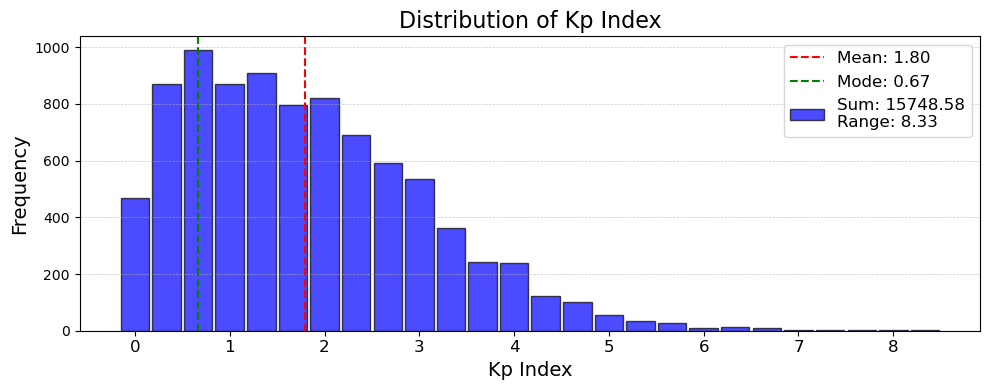

In [92]:
discrete_histogram(df['Kp Index'], "Kp Index", 0.3)

The histogram of Kp index shows the frequency of geomagnetic activity levels.

**Observations**:
  - The Kp index is heavily skewed toward lower values, indicating that most timeslots have mild geomagnetic activity.
  - Higher Kp values (above 4) are rare and correspond to geomagnetic storms


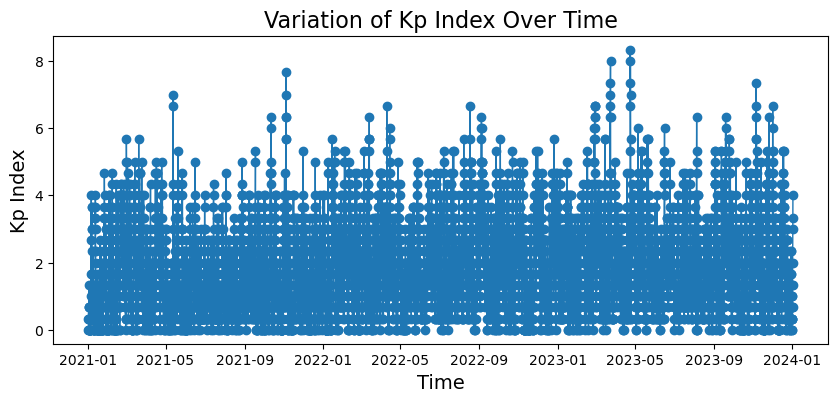

In [122]:
# Plot the Kp Index over time
plt.figure(figsize=(10, 4))
plt.plot(df['Timeslot'], df['Kp Index'], marker='o', linestyle='-', linewidth=1)
plt.title('Variation of Kp Index Over Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Kp Index', fontsize=14)
plt.show()


The scatter plot of Kp index over time highlights temporal patterns in geomagnetic activity.

**Observations**:
  - Periodic spikes in the Kp index suggest the occurrence of geomagnetic storms, likely triggered by solar activity.
  - Most timeslots cluster around lower Kp values, indicating stable geomagnetic conditions between disturbances.


## CMEs

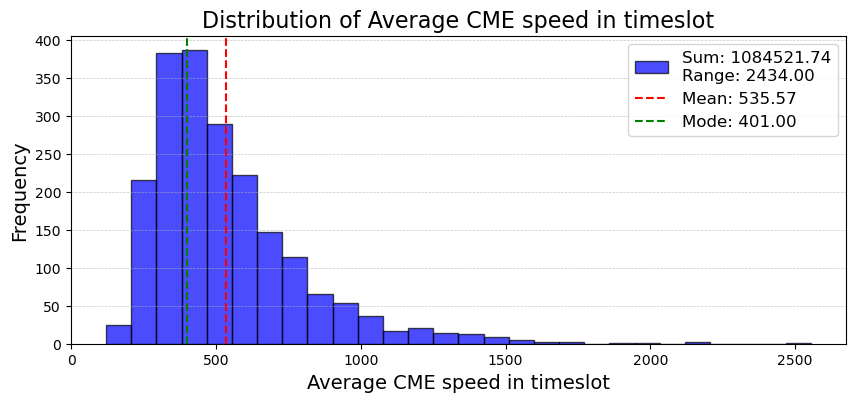

In [93]:
nondiscrete_histogram(df.dropna(subset=['Average CME speed'])['Average CME speed'], 28, "Average CME speed in timeslot")

The histogram illustrates the average speed of CMEs per timeslot.

**Observations**:
  - CME speeds are generally below 1,000 km/s, with a long tail of faster events.
  - Faster CMEs are typically rare and associated with more powerful solar eruptions, which are more likely to impact Earth.


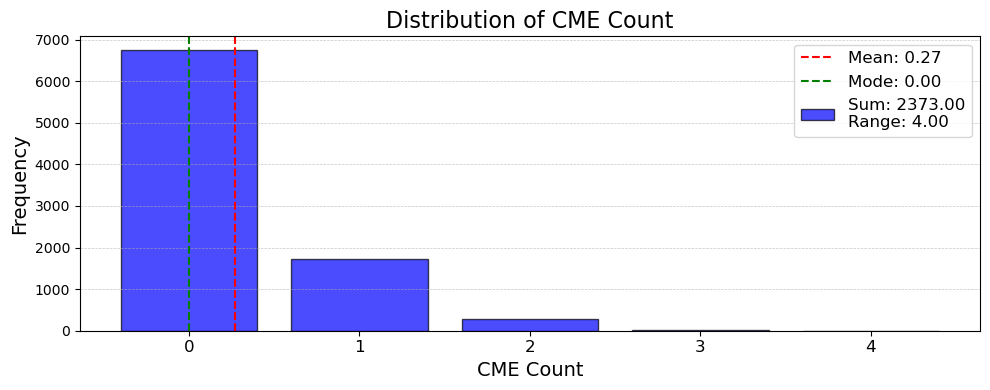

In [94]:
discrete_histogram(df['CME Count'], "CME Count", 0.8)

The histogram shows the number of CME events per timeslot.

- **Observations**:
  - The majority of timeslots have no recorded CMEs, reflecting their episodic nature.
  - Timeslots with multiple CMEs are rare but could indicate periods of heightened solar activity.


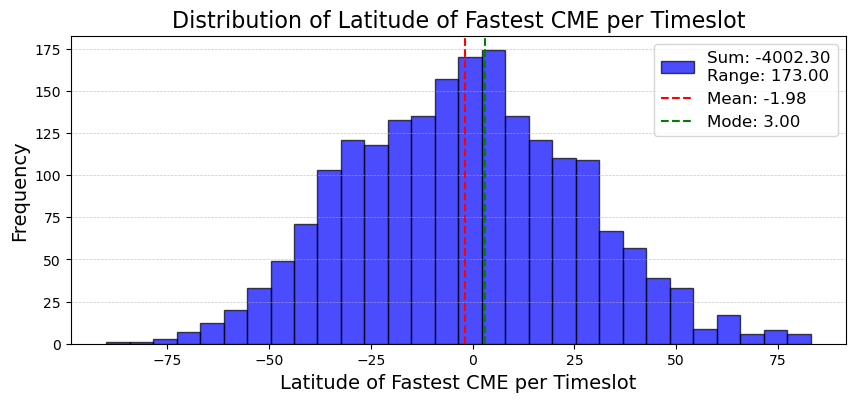

In [96]:
nondiscrete_histogram(df.dropna(subset=['CME Count'])['Latitude of Fastest CME'], 30, "Latitude of Fastest CME per Timeslot")

The histogram depicts the latitude of the fastest CME per timeslot.

**Observations**:
  - The distribution is centered around the solar equator, where most solar activity occurs.
  - The symmetry in the distribution suggests a balanced occurrence of CMEs in both hemispheres.


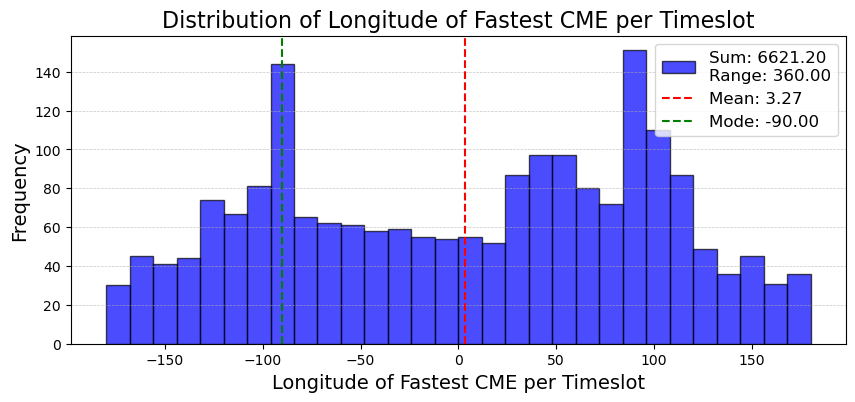

In [97]:
nondiscrete_histogram(df.dropna(subset=['CME Count'])['Longitude of Fastest CME'], 30, "Longitude of Fastest CME per Timeslot")

The histogram shows the longitude of the fastest CME per timeslot.

**Observations**:
  - CMEs are distributed relatively evenly across different longitudes, but some longitudes (e.g., -100 degrees and 100 degrees) show higher concentrations of events.


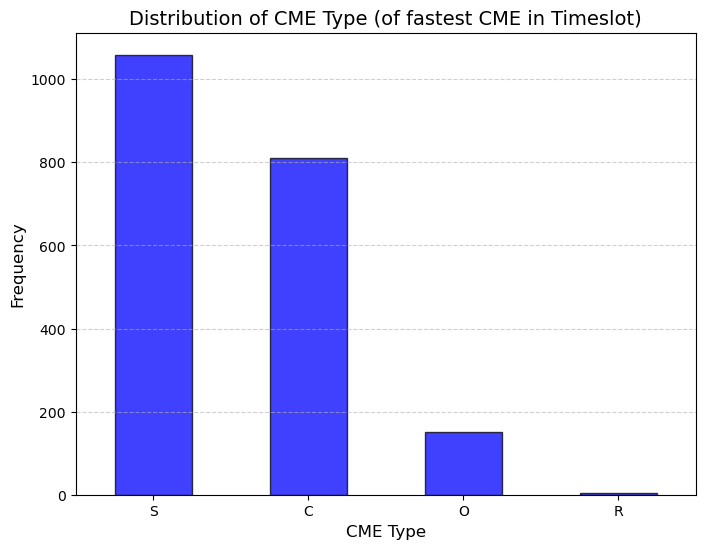

In [98]:
# Count the occurrences of each CME type
type_counts = df.dropna(subset=['CME Count'])['Fastest CME Type'].value_counts()

# Plotting the distribution
plt.figure(figsize=(8, 6))
type_counts.plot(kind='bar', alpha=0.75, color = 'blue', edgecolor='black',)
plt.title('Distribution of CME Type (of fastest CME in Timeslot)', fontsize=14)
plt.xlabel('CME Type', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0)  # Keep labels horizontal for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


The bar chart shows the frequency of CME types (S, C, O, R).

**Observations**:
  - S and C types dominate, reflecting the most common classifications of CMEs in this dataset.
  - O and R types are rare, representing unique or less frequent CME characteristics.


### Flares

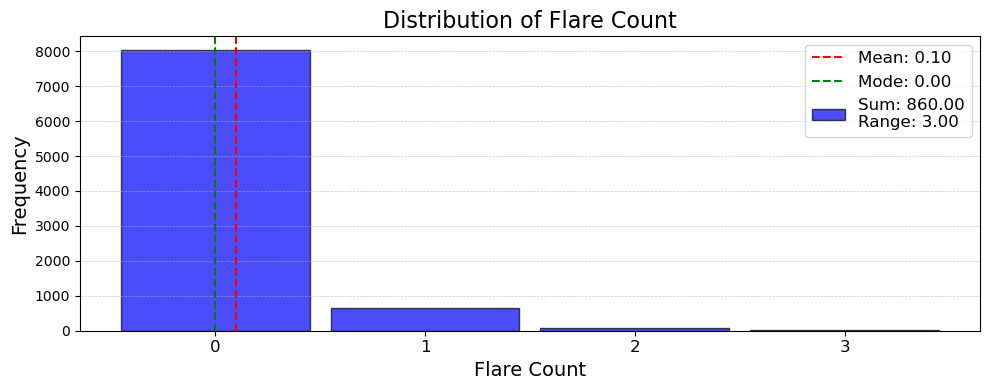

In [99]:
discrete_histogram(df['Flare Count'], "Flare Count", 0.9)

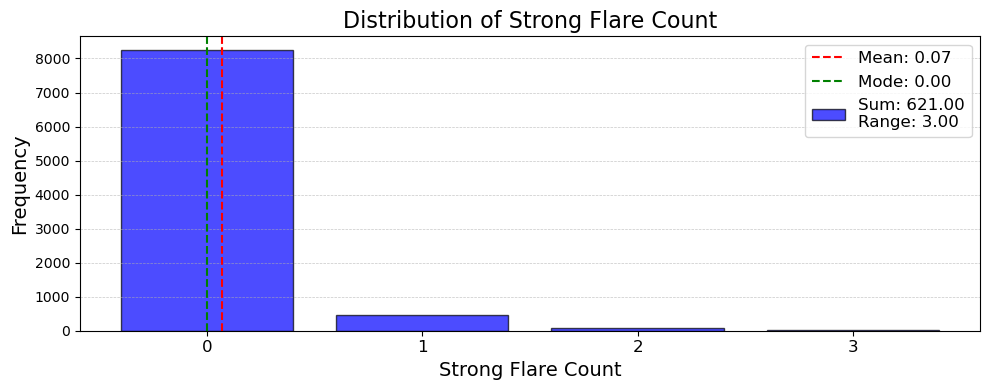

In [100]:
discrete_histogram(df['Strong Flare Count'], "Strong Flare Count", 0.8)

These histograms illustrates the number of (strong) solar flares per timeslot.

**Observations**:
  - Most timeslots have no recorded flares, indicating their sporadic nature.
  - Timeslots with higher flare counts suggest periods of intense solar activity.

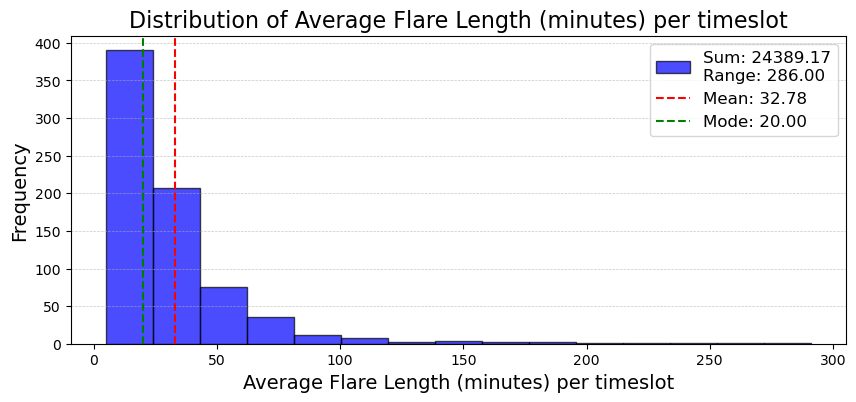

In [101]:
nondiscrete_histogram(df.dropna(subset=['Average Flare Length'])['Average Flare Length'], 15, "Average Flare Length (minutes) per timeslot")

he histogram displays the average duration of solar flares per timeslot.

**Observations**:
  - Most flares are short-lived, with durations clustering below 50 minutes.
  - Longer-lasting flares are less common


### HSS Events

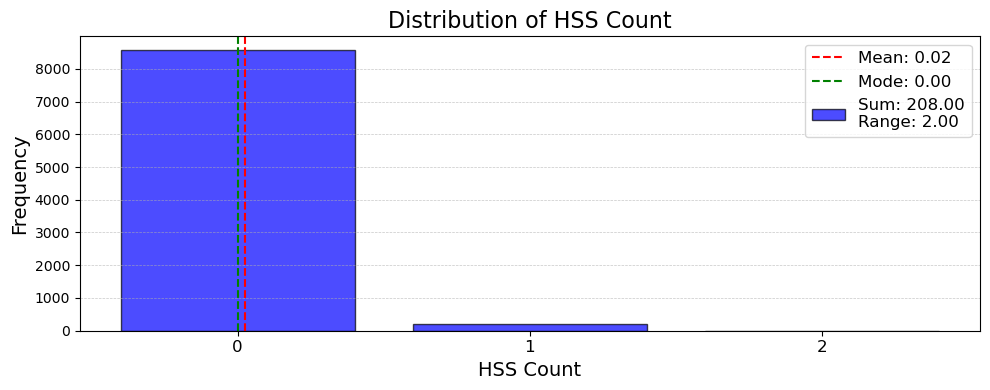

In [102]:
discrete_histogram(df['HSS Count'], "HSS Count", 0.8)

The histogram shows the count of High-Speed Solar Wind Streams (HSS) per timeslot.

**Observations**:
  - HSS events are infrequent, with most timeslots showing no occurrences.
  - HSS events are known drivers of geomagnetic activity during specific periods.

### IPS Events

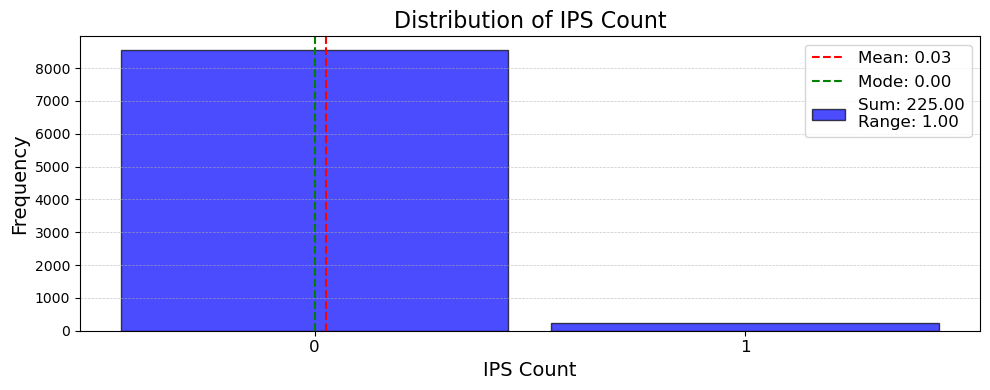

In [103]:
discrete_histogram(df['IPS Count'], "IPS Count", 0.9)

The histogram illustrates the count of Interplanetary Shocks (IPS) per timeslot.

**Observations**:
  - IPS events are rare, reflecting their unique occurrence in interplanetary space.

### Correlation

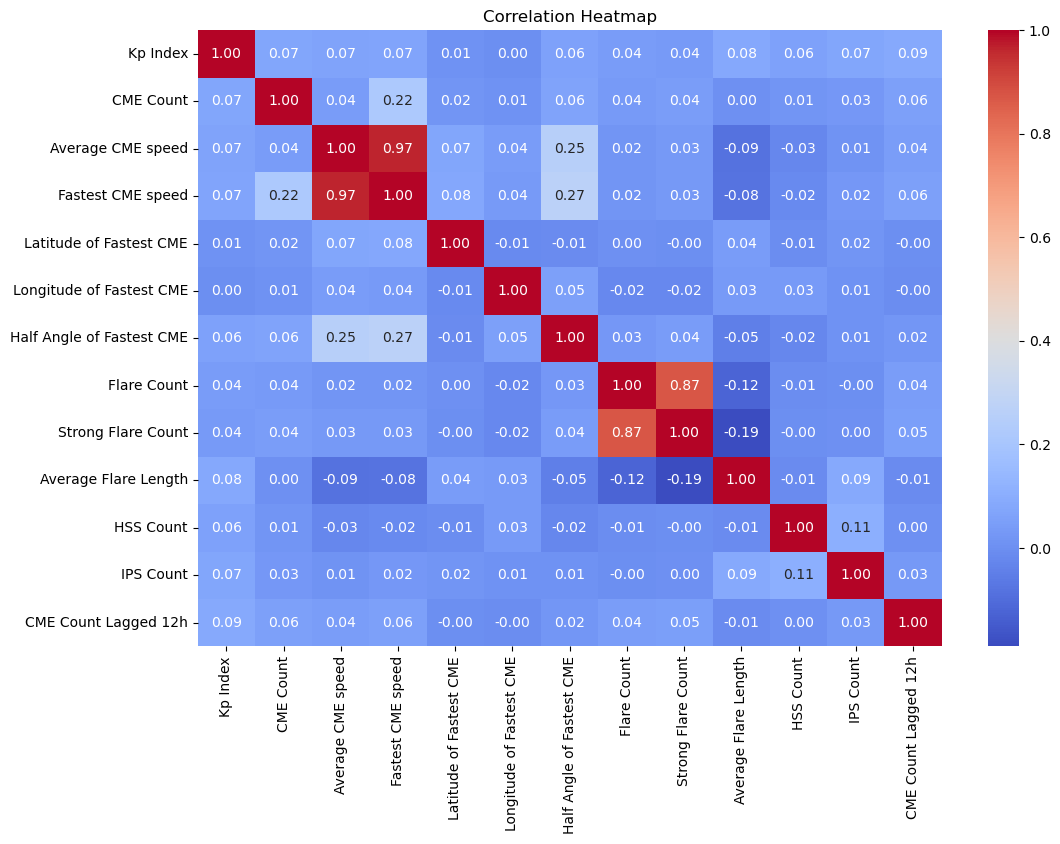

In [104]:
df['CME Count Lagged 12h'] = df['CME Count'].shift(4)  # 36 hours = 12 * 3-hour timeslots

# Heatmap of correlations
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

The heatmap shows the pairwise correlation coefficients for all features in the dataset.

**Key Observations**:
  - High correlations are observed between:
    - **Average CME Speed** and **Fastest CME Speed**: This is expected, as the fastest CME speed is a component of the average speed calculation. Such correlations should be ignored when interpreting physical relationships.
    - **Flare Count** and **Strong Flare Count**: Strong flares (M/X class) are a subset of total flares, explaining the high correlation.
  - Low correlations exist between most features, indicating weak or no linear relationships, which aligns with the complex nature of solar-terrestrial interactions.
  - **Kp Index** shows weak correlations with most features, reflecting that geomagnetic activity is influenced by multiple factors, including time delays and compounded effects from solar events.


Pearson correlation: 0.2680982006443431
p-value: 1.1246948559272018e-34


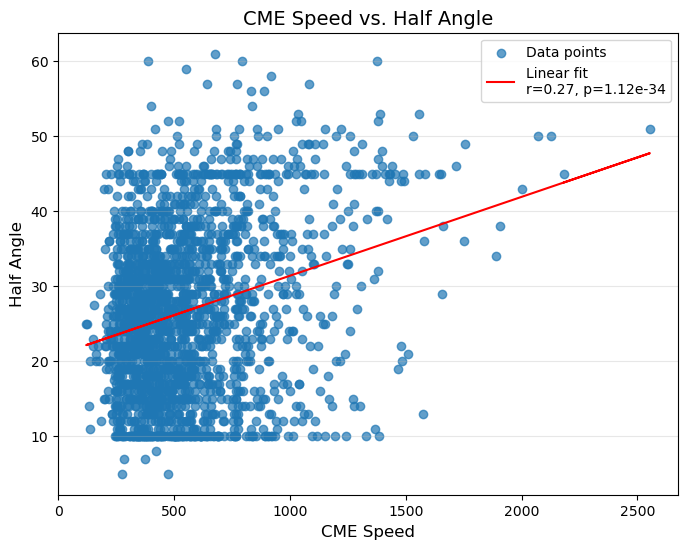

In [105]:
# Drop rows with NaN in either 'Fastest CME speed' or 'CME half angle'
filtered_df = df.dropna(subset=['Fastest CME speed', 'Half Angle of Fastest CME'])

# Extract the cleaned columns
x = filtered_df['Fastest CME speed']
y = filtered_df['Half Angle of Fastest CME']

# Calculate Spearman correlation
corr, p = pearsonr(x, y)  # Replace with spearmanr since you mentioned Spearman
print(f"Pearson correlation: {corr}")
print(f"p-value: {p}")

# Perform linear regression to get the line of best fit
slope, intercept, r_value, p_value, std_err = linregress(x, y)
line = slope * x + intercept

# Create a scatter plot with the regression line
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Data points', alpha=0.7)
plt.plot(x, line, color='red', label=f'Linear fit\nr={corr:.2f}, p={p:.2e}')  # Add regression line and legend

# Add title and labels
plt.title('CME Speed vs. Half Angle', fontsize=14)
plt.xlabel('CME Speed', fontsize=12)
plt.ylabel('Half Angle', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.legend(fontsize=10)  # Adjust legend font size

# Show the plot
plt.show()


Based on the heatmap, a moderate correlation (\( r = 0.27 \), \( p < 0.001 \)) was found between CME speed and half angle. A linear regression was performed to investigate this relationship.

- **Visualization**: The scatter plot with a linear fit shows a positive relationship between CME speed and half angle.
- **Key Observations**:
  - Faster CMEs tend to have larger half angles, suggesting that high-energy events are associated with broader ejections.
  - The low correlation indicates that other factors (e.g., magnetic field strength) likely influence the half angle.


Pearson correlation: -0.18992058366358036
p-value: 1.796910077725731e-07


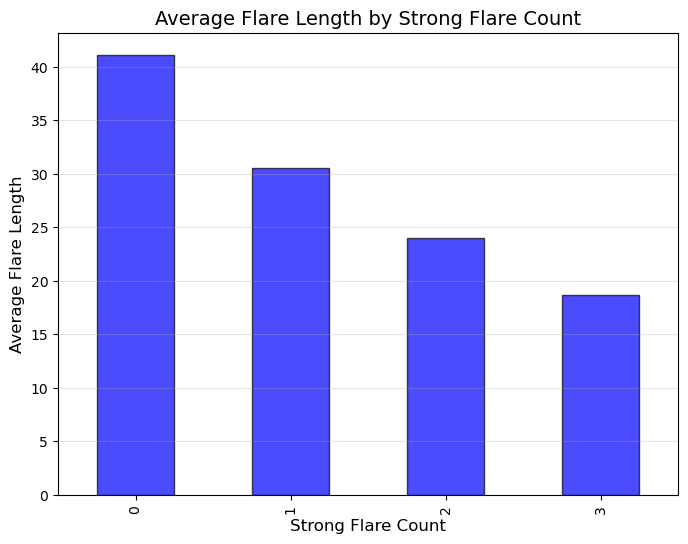

In [106]:
filtered_df = df.dropna(subset=['Average Flare Length', 'Strong Flare Count'])

#Extract the cleaned columns
x = filtered_df['Average Flare Length']
y = filtered_df['Strong Flare Count']

#Calculate Spearman correlation
corr, p = pearsonr(x, y)
print(f"Pearson correlation: {corr}")
print(f"p-value: {p}")

#Group by CME Count and calculate the mean fastest CME speed
avg_speed_per_count = filtered_df.groupby('Strong Flare Count')['Average Flare Length'].mean()

#Create a bar plot
plt.figure(figsize=(8, 6))
avg_speed_per_count.plot(kind='bar', color='blue', alpha=0.7, edgecolor='black')
plt.title('Average Flare Length by Strong Flare Count', fontsize=14)
plt.xlabel('Strong Flare Count', fontsize=12)
plt.ylabel('Average Flare Length', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

A bar chart was generated to show how the average flare length changes with the number of strong flares (M/X class) in a timeslot.

- **Key Statistics**:
  - **Pearson Correlation**: -0.19
  - **p-value**: \( 1.8 \times 10^{-7} \)
- **Visualization**: The bar chart highlights the average flare length grouped by strong flare count.
- **Key Observations**:
  - A slight negative correlation suggests that timeslots with more strong flares tend to have shorter average flare durations. This could maybe indicate that strong flares are more impulsive than weaker ones.

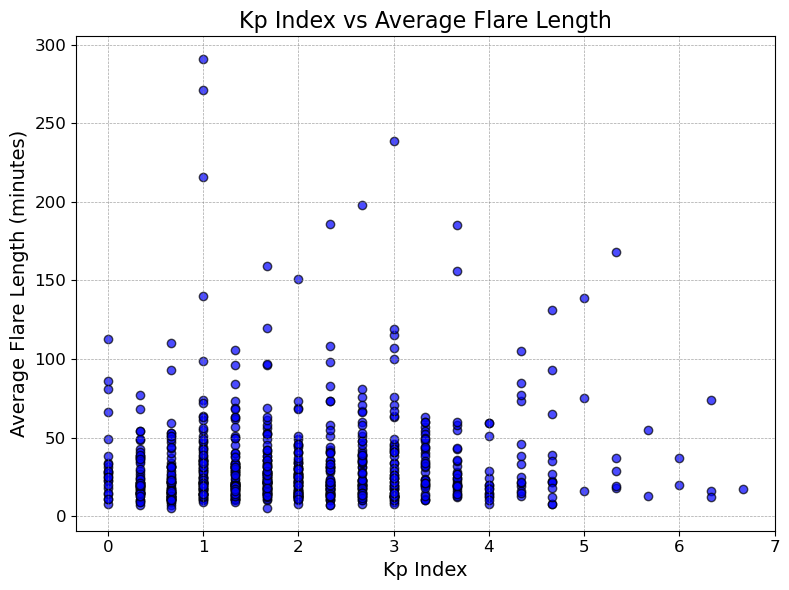

In [108]:
# Scatter plot with enhanced styling
plt.figure(figsize=(8, 6))
plt.scatter(df['Kp Index'], df['Average Flare Length'], color='blue', alpha=0.7, edgecolor='black')

# Add title and labels
plt.title('Kp Index vs Average Flare Length', fontsize=16)
plt.xlabel('Kp Index', fontsize=14)
plt.ylabel('Average Flare Length (minutes)', fontsize=14)

# Add gridlines
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust ticks for readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a subtle box around the plot
plt.tight_layout()

# Show the plot
plt.show()


A scatter plot was generated to visualize the relationship between Kp index and average flare length, demonstrating the minimal correlation between most features.

- **Key Statistics**:
  - The scatter plot shows no discernible trend between the two features.
- **Key Observations**:
  - The lack of correlation reflects the complexity of how solar activity impacts Earth’s geomagnetic environment. Flare length alone does not significantly influence geomagnetic activity, as multiple other factors (e.g., flare energy, CME presence) play a role.

The correlation analysis highlights the generally weak relationships between most features, emphasizing the complexity of solar and geomagnetic phenomena. Stronger correlations, such as those between CME speed and half angle or flare count and strong flare count, align with physical expectations and provide insights for further investigation.

The weak correlations observed across most features suggest that maybe important relationships may occur over different time scales or lagged effects. This motivated further analysis of correlations across varying time lags in Step 4, particularly focusing on features such as CME count and their delayed impact on the Kp index.

# Step 4: Ask question about your data

In [143]:
df = pd.read_csv('merged_data.csv')

# Convert Timeslot to datetime for easier manipulation
df['Timeslot'] = pd.to_datetime(df['Timeslot'])


# How do HSS, CME, IPS, and solar flare events relate to changes in the Kp Index across hourly, daily and monthly timescales?

## Is there a lag in correlation between solar events and Kp index spikes?

#### Intent
The Kp index, which measures geomagnetic activity, often reacts to solar events (e.g., HSS, CME, IPS, and solar flares) after a delay. This analysis investigates whether there is a lag in the correlation between solar events and spikes in the Kp index. By calculating correlations across varying lags (in hours), we aim to identify time delays in the impact of these events on geomagnetic activity.

---

#### Methodology
1. **Lagged Correlation Calculation**:
   - For each solar event type (e.g., HSS Count, CME Count, etc.), the correlation with the Kp index was computed across lags ranging from -150 to +150 hours.
   - Lags were implemented by shifting the event column by a specified number of time slots (e.g., a 12-hour lag corresponds to 4 timeslots).
   - The lag with the maximum correlation was identified and visualized.
   

2. **Visualization**:
   - The relationship between lag and correlation coefficient was plotted for each solar event type.
   - A red vertical line indicates the lag with the maximum correlation, and the corresponding value is annotated in the legend.


In [146]:
def lagged_correlation(column_name):
    
    max_lag = 50  #Define maximum lag in terms of index shifts
    lags = np.arange(-max_lag, max_lag + 1)  #Create an array for lags

    correlations = []
    
    for lag in lags:
        correlation = df[column_name].shift(lag).corr(df['Kp Index'])
        correlations.append(correlation)
        
        
    #Find the lag corresponding to the maximum correlation
    max_corr_index = np.argmax(correlations)  
    max_corr_lag = lags[max_corr_index] 


    #Plot lag vs. correlation coefficient
    plt.figure(figsize=(10, 6))
    plt.plot(lags*3, correlations, marker='o')
    plt.axvline(max_corr_lag*3, color = 'red', label = f"maximum correlation ({max(correlations):.2f}) at {max_corr_lag*3} hour lag")
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.title(f"Lag vs. Correlation Coefficient between {column_name} and Kp Index")
    plt.xlabel("Lag (hours)")
    plt.ylabel("Correlation Coefficient")
    plt.legend()
    plt.grid()
    plt.show()
    

### HSS events 

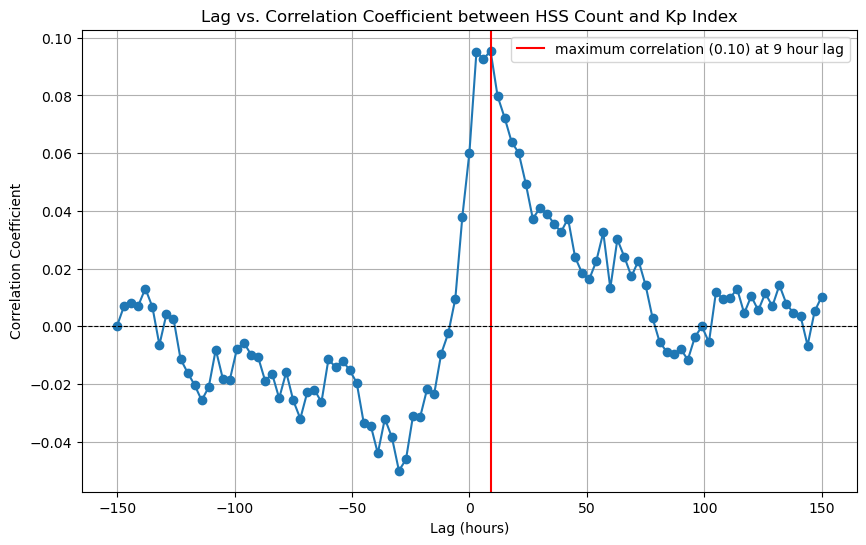

In [145]:
lagged_correlation('HSS Count')

- **Visualization**: The correlation increases sharply near 0 lag and peaks at a 9-hour lag with a maximum correlation of 0.10.
- **Interpretation**:
  - This clear and sharp peak indicates that high-speed solar wind streams (HSS) influence Earth's geomagnetic activity quickly after their detection, with a delay of about 9 hours.
  - The symmetry and smooth increase around 0 lag show a direct and timely response of the Kp index to HSS events.



### CME events

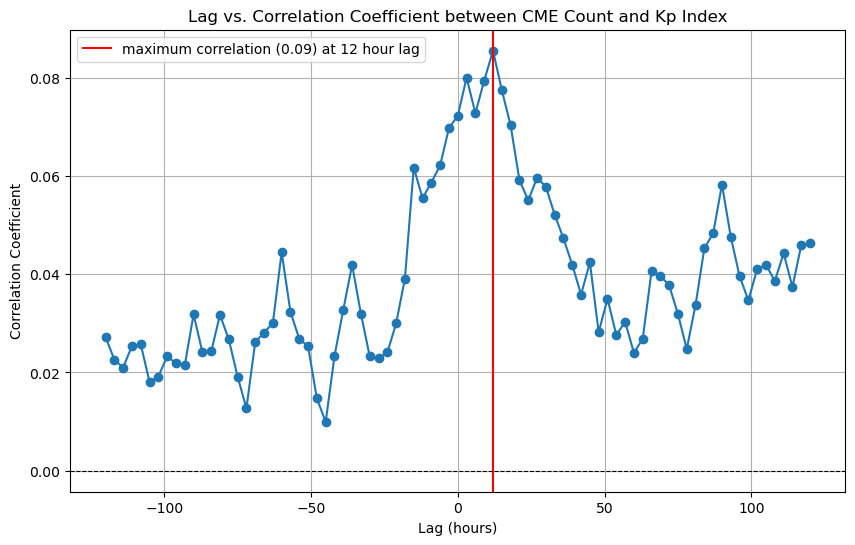

In [112]:
lagged_correlation('CME Count')

- **Visualization**: The graph is less clear, with no sharp peak and a maximum correlation of 0.09 at a 12-hour lag.
- **Interpretation**:
  - CMEs take slightly longer to influence the Kp index compared to HSS and IPS events, possibly due to their slower transit or interaction dynamics with Earth's magnetosphere.
  - The weak and scattered nature of the graph suggests that CMEs are not the sole factor influencing geomagnetic disturbances during these timescales.


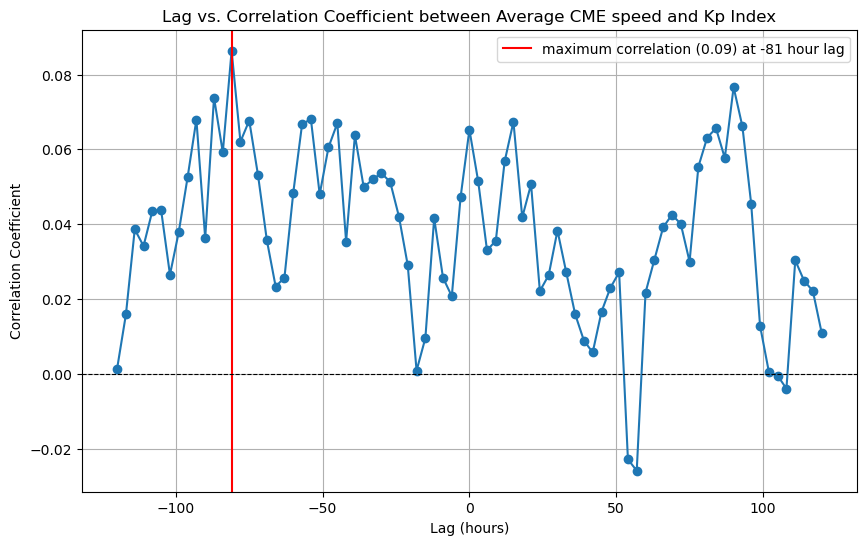

In [113]:
lagged_correlation('Average CME speed')

- **Visualization**: The graph is messy, with no distinct peak and a maximum correlation of 0.09 at -81 hours.
- **Interpretation**:
  - The graph is messy, meaning no conclusions can be drawn


### IPS events

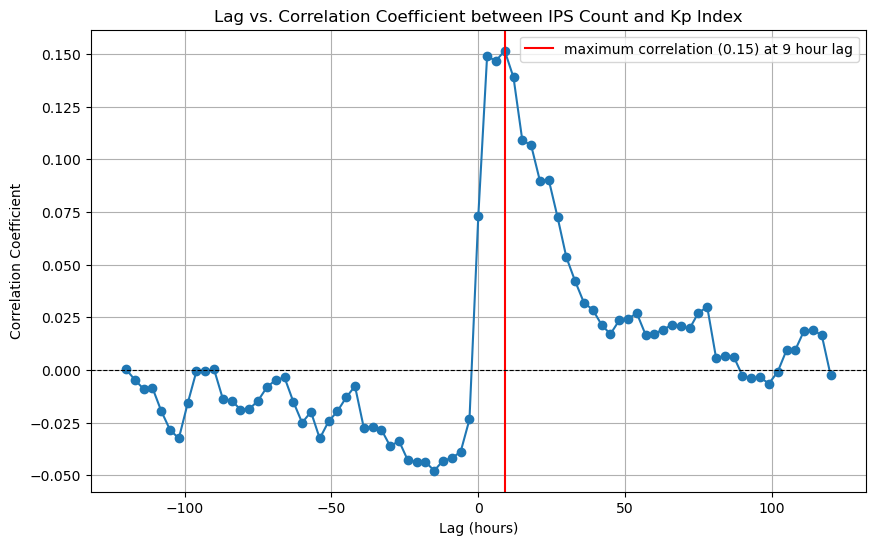

In [114]:
lagged_correlation('IPS Count')

- **Visualization**: Similar to HSS, the correlation rises sharply around 0 lag, and peaks at a 9-hour lag with a maximum correlation of 0.15.
- **Interpretation**:
  - Interplanetary shocks (IPS) have an almost immediate impact on the Kp index. This aligns with their fast propagation and interaction with the magnetosphere.
  - The timing and clarity of this graph indicate that IPS events are a strong driver of short-term geomagnetic activity changes.


### Solar flare events

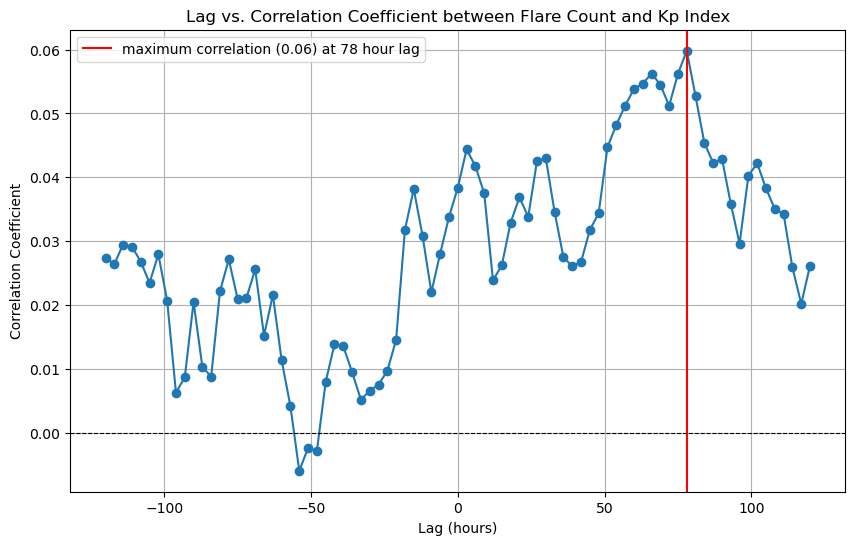

In [115]:
lagged_correlation('Flare Count')

- **Visualization**: The graph shows weak correlation overall, with a maximum of 0.06 at a 78-hour lag.
- **Interpretation**:
  - The lack of a sharp increase or clear pattern suggests that flare count alone does not significantly drive geomagnetic activity on these timescales, and it is hard to draw a conclusion.


#### Summary
The lagged correlation analysis reveals distinct differences in the timing and clarity of solar events’ effects on the Kp index:
- **HSS Count and IPS Count**: Both show clear patterns, with sharp increases and peaks at around 9 hours, indicating their rapid and direct influence on geomagnetic activity.
- **CME Count and Average CME Speed**: These graphs are messier. They have weaker correlations and scattered patterns. While CMEs may contribute to geomagnetic disturbances, their influence appears less direct on these timescales.
- **Flare Count**: The weak and delayed correlations highlight that solar flares may indirectly influence the Kp index but are not strong standalone predictors.

The timing differences between events (e.g., HSS and IPS events peaking at 9 hours, CMEs peaking at 12 hours) show the interaction speeds solar events as they interact with Earth's magnetosphere.

## Do certain events significantly influence the Kp Index compared to days without these events?

#### Intent
To understand whether specific solar events (HSS, IPS, CME, and solar flares) have a significant impact on the Kp Index, I compared daily average Kp values on days with these events to days without them. This helps identify whether the presence of these events corresponds to measurable increases in geomagnetic activity.

---

#### Methodology
1. **Daily Resolution**:
   - I resampled the data set to daily resolution, calculating the mean daily Kp Index and the total count of each event type (e.g., HSS Count, IPS Count).
   

2. **Statistical Test**:
   - I used the Mann-Whitney U test to compare the distributions of Kp Index values for days with events ("event days") versus days without events ("non-event days").
   - I chose the Mann-Whitney U test because it is non-parametric, so it doesn’t assume the data is normally distributed. This is important because the Kp Index distribution is skewed (as seen earlier), and the solar event data can be sparse.

In [160]:
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

def daily_event_influence(column_name):
    # Aggregate by day
    df_resampled_daily = df.resample('D', on='Timeslot').agg({
        'Kp Index': 'mean',
        column_name: 'sum'
    }).reset_index()

    # Compare periods with and without any event
    event_group = df_resampled_daily[df_resampled_daily[column_name] > 0]['Kp Index']
    no_event_group = df_resampled_daily[df_resampled_daily[column_name] == 0]['Kp Index']

    if len(event_group) > 1 and len(no_event_group) > 1:
        # Mann-Whitney U test
        u_stat, u_p_value = mannwhitneyu(event_group, no_event_group, alternative='two-sided')
        print(f"Mann-Whitney U Statistic: {u_stat}, P-value: {u_p_value}")
        
        # Create a new column to label days
        df_resampled_daily['Event Label'] = df_resampled_daily[column_name].apply(lambda x: 'With Event' if x > 0 else 'Without Event')

        print(f"Number of days with event: {len(event_group)}")
        print(f"Number of days without event: {len(no_event_group)}")
    else:
        print("Insufficient data for statistical tests.")
        print(f"Number of days with event: {len(event_group)}")
        print(f"Number of days without event: {len(no_event_group)}")


### HSS events

In [161]:
daily_event_influence('HSS Count')

Mann-Whitney U Statistic: 111883.0, P-value: 5.680813215722874e-10
Number of days with event: 193
Number of days without event: 903


### IPS events

In [162]:
daily_event_influence('IPS Count')

Mann-Whitney U Statistic: 123661.0, P-value: 2.325892919446884e-11
Number of days with event: 218
Number of days without event: 878


### CME events

In [163]:
df['CME Event'] = (df['CME Count'] != 0).astype(int)
daily_event_influence('CME Event')

Mann-Whitney U Statistic: 112063.0, P-value: 6.318152158125634e-07
Number of days with event: 890
Number of days without event: 206


### Flare Events

In [164]:
df['Flare Event'] = (df['Flare Count'] != 0).astype(int)
daily_event_influence('Flare Event')

Mann-Whitney U Statistic: 153343.0, P-value: 0.011223455099691557
Number of days with event: 409
Number of days without event: 687


### Combination of IPS, CME and HSS events

In [165]:
df['HSS, CME and IPS Events'] = ((df['HSS Count'] != 0) | (df['IPS Count'] != 0) | df['CME Count'] != 0).astype(int)
daily_event_influence('HSS, CME and IPS Events')


Mann-Whitney U Statistic: 94445.5, P-value: 2.875124829570571e-11
Number of days with event: 947
Number of days without event: 149


### Sub-question 2: Do certain events significantly influence the Kp Index compared to days without these events?

#### Results and Observations

**1. HSS Events**:
  - The low p-value strongly rejects the null hypothesis, meaning the Kp Index on days with HSS events is significantly different from days without them.
  - The relatively high U statistic means there is a separation between the two groups, with higher Kp values on event days.
  - This is expected, as HSS events are known to drive geomagnetic activity quickly and significantly.

**2. IPS Events**:
  - The extremely low p-value indicates a significant difference in Kp Index between IPS event days and non-event days.
  - The U statistic is even higher than that for HSS events. This suggests a clear separation between the groups.
  - This reflects the conclusion I drew earlier that IPS events are strong drivers of geomagnetic activity on a small timescale

**3. CME Events**:
  - While the p-value shows significance, it is higher than for HSS or IPS events. This means it has a smaller effect.
  - The lower U statistic compared to IPS and HSS reflects a weaker separation between event and non-event groups.
  - CMEs may influence geomagnetic activity less consistently or through more complex mechanisms, as shown by the noisier results.

**4. Flare Events**:
  - The higher p-value and lower U statistic suggest a weaker influence of flare events on the Kp Index.
  - This reflects my earlier discussion that solar flares impact the Kp index less directly.

**5. Combination of HSS, IPS, and CME Events**:
  - The very low p-value and high U statistic indicate a strong and significant combined effect of these events on the Kp Index.
  - Combining HSS, IPS, and CME events probably amplifies their effects


## Are there monthly patterns in Kp Index variations driven by specific events?

#### Intent
For this part of the analysis, I wanted to figure out if there are any clear monthly trends in the Kp Index that could be linked to specific solar events, like CMEs, HSS, IPS, or flares. I thought that aggregating the data by month and comparing the average Kp Index with the frequency and intensity of these events might help uncover patterns. I also wanted to see if some events were more strongly associated with higher Kp values on a broader timescale.

---

#### Methodology
1. **Grouping the Data**:
   - I grouped the data by year and month to calculate the monthly average Kp Index and the total counts of each event type (HSS, IPS, CME, flare counts, and strong flare counts).
   - For the CME speed, I used a weighted average approach where the CME Count was the weight. I thought this would give a more accurate representation of how significant CMEs affect each month since higher-speed CMEs probably cause more geomagnetic disturbance.

2. **Visualizing Patterns**:
   - I plotted a bar chart to compare the Kp Index (scaled for comparison) alongside the counts of CME and flare events over time. I thought this would make it easier to spot if there’s any clear relationship between these events and the Kp Index trends.
   - I also created scatterplots with regression lines to visualize how strongly the Kp Index correlates with different metrics, like CME Count, Average CME Speed, Flare Count, and Strong Flare Count.

3. **Analyzing Correlations**:
   - To back up the visual observations, I calculated Pearson correlations between the Kp Index and each event type. I focused on correlations with a p-value less than 0.1, as those are more statistically significant.


In [167]:
# Add Year and Month columns
df['Year'] = df['Timeslot'].dt.year
df['Month'] = df['Timeslot'].dt.month

# Define a function for weighted average with zero-weight handling
def weighted_average(values, weights):
    if weights.sum() == 0:  # Handle cases where the sum of weights is zero
        return 0
    return (values * weights).sum() / weights.sum()

# Aggregate Kp Index and event counts by Year and Month
monthly_data = df.groupby(['Year', 'Month']).agg({
    'Kp Index': 'mean',
    'HSS Count': 'sum',
    'IPS Count': 'sum',
    'CME Count': 'sum',
    'Flare Count': 'sum',
    'Strong Flare Count': 'sum'
}).reset_index()

# Calculate weighted average of CME speed using CME Count
monthly_data['Average CME speed'] = df.groupby(['Year', 'Month']).apply(
    lambda group: weighted_average(group['Average CME speed'], group['CME Count'])
).values

# Calculate weighted sum of flare time using Flare Count
monthly_data['Total Flare Time'] = df.groupby(['Year', 'Month']).apply(
    lambda group: (group['Average Flare Length'] * group['Flare Count']).sum()
).values


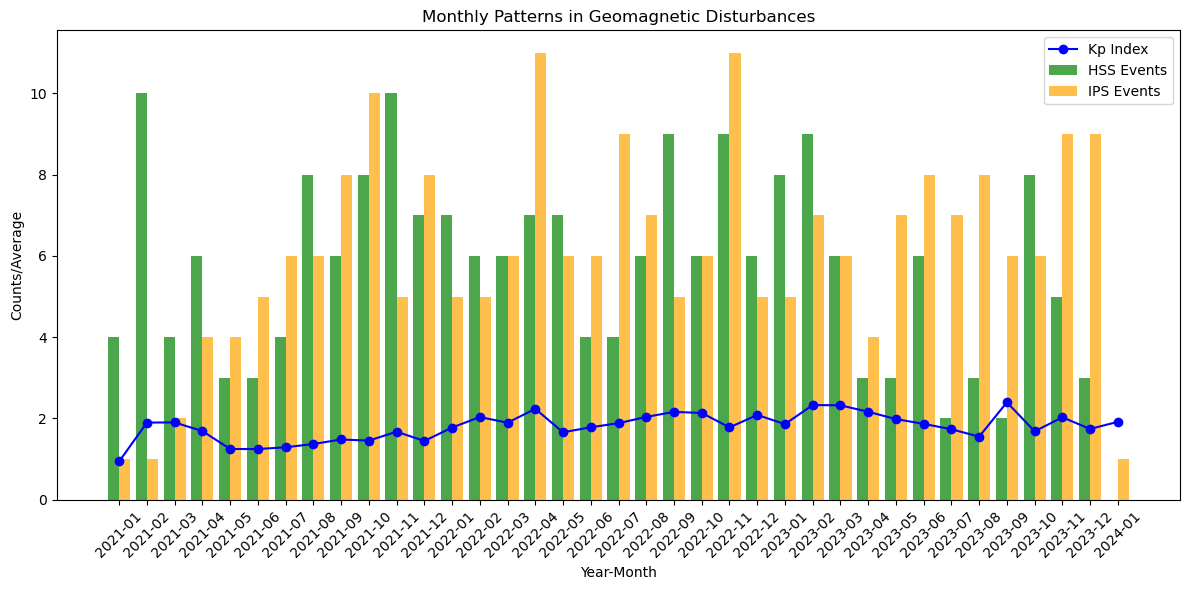

In [168]:
# Create a new column for Year-Month (formatted as YYYY-MM)
monthly_data['Year-Month'] = monthly_data['Year'].astype(str) + '-' + monthly_data['Month'].astype(str).str.zfill(2)

# Define x-axis positions based on Year-Month
x = range(len(monthly_data))  # Sequential x-axis positions
bar_width = 0.4
x_hss = [xi - bar_width / 2 for xi in x]
x_ips = [xi + bar_width / 2 for xi in x]

# Create side-by-side bar plots
plt.figure(figsize=(12, 6))
plt.plot(x, monthly_data['Kp Index'], marker='o', color='blue', label='Kp Index')
plt.bar(x_hss, monthly_data['HSS Count'], width=bar_width, alpha=0.7, color='green', label='HSS Events')
plt.bar(x_ips, monthly_data['IPS Count'], width=bar_width, alpha=0.7, color='orange', label='IPS Events')

# Customize the x-axis to show Year-Month labels
plt.xticks(x, monthly_data['Year-Month'], rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Counts/Average')
plt.title('Monthly Patterns in Geomagnetic Disturbances')
plt.legend()
plt.tight_layout()
plt.show()


It is not imediately clear that months with more CMEs and flares tend to have higher Kp Index values. But, there are peaks in CME and flare activity during some months where the Kp Index also spiked.

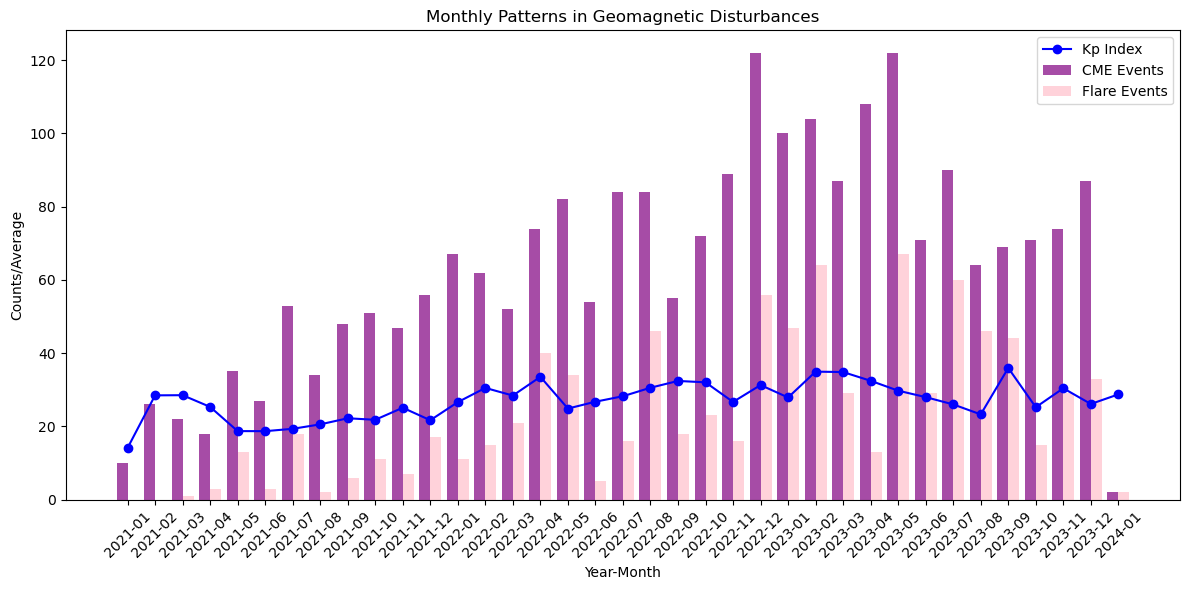

In [169]:
# Create a new column for Year-Month (formatted as YYYY-MM)
monthly_data['Year-Month'] = monthly_data['Year'].astype(str) + '-' + monthly_data['Month'].astype(str).str.zfill(2)

# Define x-axis positions based on Year-Month
x = range(len(monthly_data))  # Sequential x-axis positions
bar_width = 0.4
x_hss = [xi - bar_width / 2 for xi in x]
x_ips = [xi + bar_width / 2 for xi in x]

# Create side-by-side bar plots
plt.figure(figsize=(12, 6))
plt.plot(x, monthly_data['Kp Index']*15, marker='o', color='blue', label='Kp Index')
plt.bar(x_hss, monthly_data['CME Count'], width=bar_width, alpha=0.7, color='purple', label='CME Events')
plt.bar(x_ips, monthly_data['Flare Count'], width=bar_width, alpha=0.7, color='pink', label='Flare Events')

# Customize the x-axis to show Year-Month labels
plt.xticks(x, monthly_data['Year-Month'], rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Counts/Average')
plt.title('Monthly Patterns in Geomagnetic Disturbances')
plt.legend()
plt.tight_layout()
plt.show()


It is not imediately clear that months with more solar events tend to have higher Kp Index values. But, there are peaks in solar activity during some months where the Kp Index also spiked.

In [171]:
def monthly_correlation(column_name):
    corr, p = pearsonr(monthly_data[column_name], monthly_data['Kp Index'])
    if p < 0.1:
        print(f"{column_name} and Kp Index: {corr}, P-value: {p}")
    return corr

In [172]:
print(f"Correlation between :")
cme_corr = monthly_correlation('CME Count')
average_cme_corr = monthly_correlation('Average CME speed')
hss_corr = monthly_correlation('HSS Count')
ips_corr = monthly_correlation('IPS Count')
flare_corr = monthly_correlation('Flare Count')
strong_flare_corr = monthly_correlation('Strong Flare Count')
flare_time_corr = monthly_correlation('Total Flare Time')


Correlation between :
CME Count and Kp Index: 0.5319523631637668, P-value: 0.000702748538934696
Average CME speed and Kp Index: 0.31189506028887803, P-value: 0.060210426042217116
Flare Count and Kp Index: 0.4707207989337954, P-value: 0.0032790526004565983
Strong Flare Count and Kp Index: 0.49742284685593186, P-value: 0.0017343519264996958
Total Flare Time and Kp Index: 0.4807664486010293, P-value: 0.0025957232889176705


In [173]:
def plot_monthly_corr(column_name, corr):
    plt.figure(figsize=(8, 6))
    sns.regplot(
        x=monthly_data[column_name],
        y=monthly_data['Kp Index'],
        line_kws={'label': f"Correlation: {corr:.2f}"},
    )
    plt.title(f'{column_name} vs. Kp Index by month')
    plt.xlabel(f'{column_name} per month')
    plt.ylabel('Average Kp Index')
    plt.legend()
    plt.tight_layout()  # Fix overlapping layout
    plt.show()

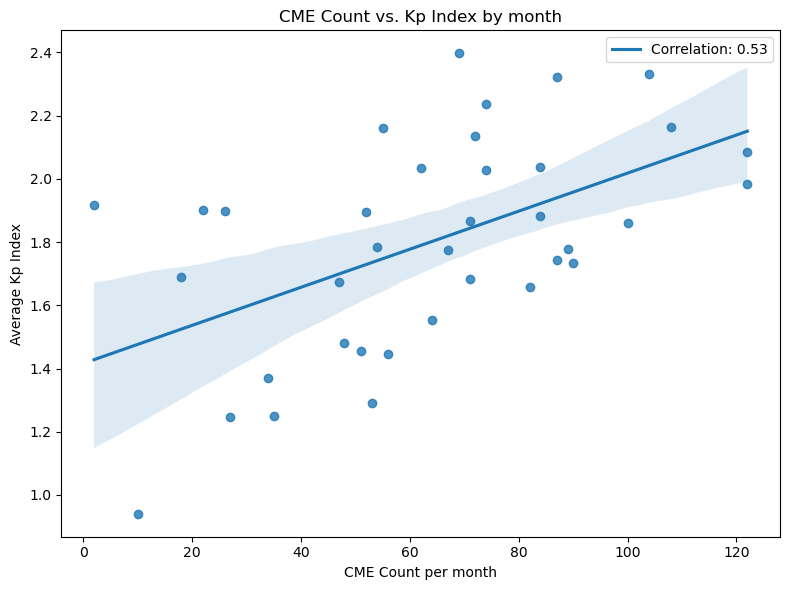

In [174]:
plot_monthly_corr('CME Count', cme_corr)

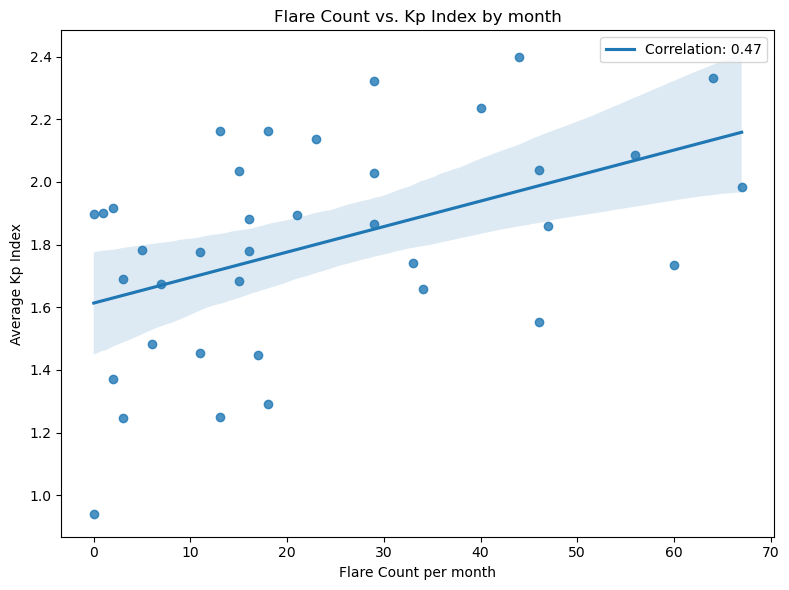

In [175]:
plot_monthly_corr('Flare Count', flare_corr)

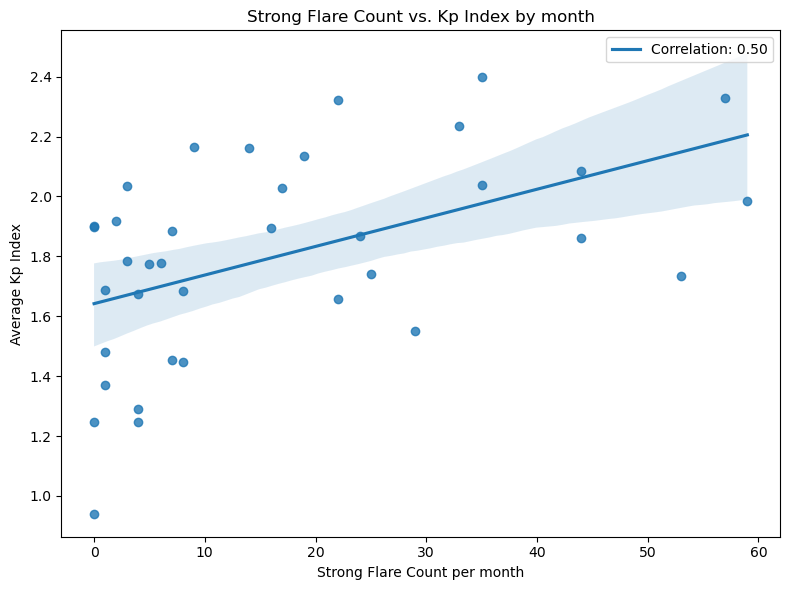

In [176]:
plot_monthly_corr('Strong Flare Count', strong_flare_corr)

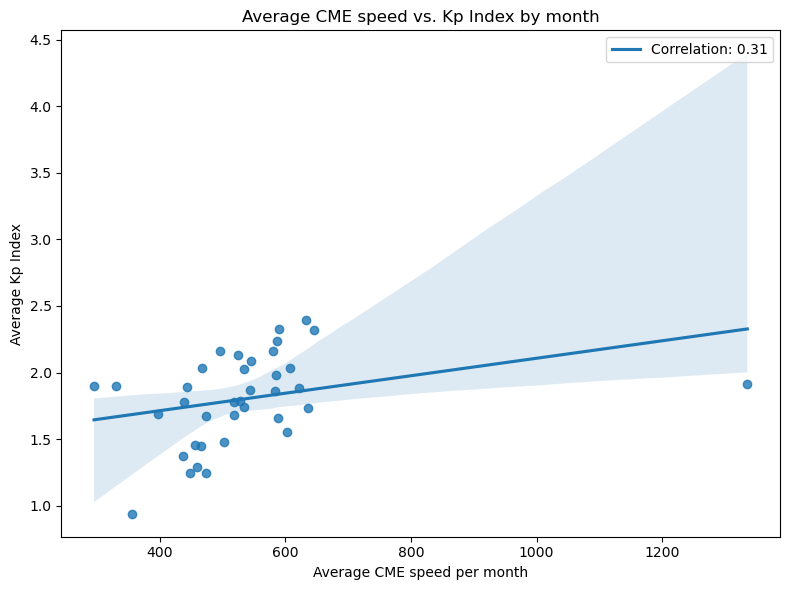

In [177]:
plot_monthly_corr('Average CME speed', average_cme_corr)

**Correlation Between CME Count and Kp Index**:
- **Results**: The Pearson correlation was 0.53, with a p-value of 0.0007.
- **Scatterplot**: The scatterplot highlights a clear positive trend where months with higher CME counts correspond to higher average Kp Index values. This supports the idea that increased CME activity contributes to stronger geomagnetic disturbances.
- **Interpretation**: This moderate correlation aligns with expectations, as CMEs are one of the primary drivers of geomagnetic storms. The relationship suggests that the frequency of CMEs has a noticeable impact on the Kp Index.

**Correlation Between Flare Counts and Kp Index**:
- **Flare Count**: Pearson correlation = 0.47, p-value = 0.003.
- **Strong Flare Count**: Pearson correlation = 0.50, p-value = 0.0017.
- **Observations**: Both flare counts and strong flare counts show positive correlations with the Kp Index. The scatterplots shows some variability, but the positive correlation is there. Strong flares exhibit a slightly stronger correlation, which is consistent with their higher energy output.
- **Interpretation**: Flares might not directly impact geomagnetic activity but are often linked with CMEs, which could explain their contribution to the Kp Index. 

**Correlation Between Average CME Speed and Kp Index**:
- **Results**: Pearson correlation = 0.31, p-value = 0.06.
- **Scatterplot**: The scatterplot shows a weaker positive trend compared to CME count, with greater variability in the relationship between average CME speed and Kp Index.
- **Interpretation**: The weaker correlation might be due to average CME speed not fully capturing the impact of particularly high-speed CMEs, which can drive more significant geomagnetic storms. Other factors, such as the density also play a role.

**Total Flare Time and Kp Index**:
- **Results**: Pearson correlation = 0.48, p-value = 0.0026.
- **Scatterplot**: The total flare time per month shows a moderate positive correlation with the Kp Index. Months with longer flare durations tend to have higher Kp Index values.
- **Interpretation**: This result suggests that the cumulative duration of flare activity mayimpact the Kp indec. Longer flares mean more sustained energy release, which could contribute to higher Kp values.


# Step 5: Conlcusion

From this analysis, I was able to explore the relationships between solar events and geomagnetic disturbances, as measured by the Kp Index. By examining the data across different timescales (hourly, daily, and monthly), I observed that certain types of solar events, such as CMEs and flares, have a noticeable impact on the Kp Index, particularly when analyzed on broader timescales. 

- **Key Findings**:
  - CMEs showed the strongest relationship with the Kp Index, especially in terms of monthly CME counts. This aligns with their known role in driving geomagnetic disturbances.
  - Solar flares, particularly strong flares, also exhibited moderate correlations with the Kp Index, suggesting that their energy release contributes indirectly to geomagnetic activity, likely through associated phenomena like CMEs.
  - Average CME speed and flare duration showed weaker correlations, likely due to the variability in the direction and density of CMEs or the cumulative impact of flares being less direct.
  - On shorter timescales (hourly and daily), HSS and IPS events demonstrated clearer and more immediate relationships with Kp Index spikes, which fits their expected faster impacts on Earth's geomagnetic field.

While these insights helped quantify some of the expected relationships, the overall correlations were weaker than anticipated. This could be due to the inherent complexity of space weather phenomena, where factors like magnetic orientation, solar wind density, and Earth’s geomagnetic conditions play significant roles but were not fully captured in this dataset. 

---

### Reflections on the Approach and Challenges

A big limitation was the relatively weak correlations between the Kp Index and most variables, which made identifying clear patterns challenging. To address this, I explored correlations at different timescales and included lag analyses to better understand the temporal relationships, which added depth to the findings.

---

### Ideas for Future Work

There is significant potential to build on this work by incorporating. My choice of solar weather data was mostly due to what I could access through APIs. 

1. **Incorporate More Detailed CME Data**:
   - Including magnetic field orientation (e.g., Bz values) and plasma density data could help better explain the variability in the Kp Index.
   - Using higher-resolution data, such as 1-minute solar wind measurements, might capture more immediate impacts.

2. **Expand the Dataset**:
   - Including datasets on other solar phenomena, such as coronal holes, or data on Earth’s geomagnetic conditions could provide a more comprehensive picture.
   - Adding longer-term data (e.g., spanning multiple solar cycles) would help uncover broader trends.

3. **Model Lagged Impacts**:
   - The lag analysis highlighted some interesting temporal patterns, particularly for HSS and IPS events. Future work could focus on predictive modeling to understand the delayed effects of different events on the Kp Index.

4. **Machine Learning Approaches**:
   - Using machine learning models to predict the Kp Index based on solar event data could help better quantify the contributions of various factors, especially when correlations alone are insufficient.

5. **Explore Other Indices**:
   - The Kp Index is just one measure of geomagnetic activity. Including other indices, like the Dst (Disturbance Storm Time) index, might provide complementary insights into the impacts of solar events.

